# Assignment 12: Introspection Part 1 - Kai Ponel & Hannan Mahadik

# Imports & Google Drive

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from random import randint

import keras
import keras.layers as layers
from keras.models import Model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D, BatchNormalization, Dropout, InputLayer
from tensorflow.keras.layers import RandomFlip, RandomRotation

In [2]:
import os

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# CIFAR10 Dataset

		frog


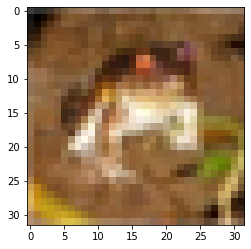

In [286]:
cifar10 = tf.keras.datasets.cifar10

(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

label_def = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

plt.imshow(train_images[0])
print('\t\t' + label_def[train_labels[0][0]])

In [287]:
### Dataset stuff
# Converting the pixels data to float type
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')
 
train_images = train_images / 255
test_images = test_images / 255 

train_images_ds = tf.data.Dataset.from_tensor_slices(train_images)
train_labels_ds = tf.data.Dataset.from_tensor_slices(train_labels)

train_data = tf.data.Dataset.zip((train_images_ds, train_labels_ds))

# Early Stopping Callback

In [11]:
### Define the early stopping callback (This is used in multiple models)
early_stopping = tf.keras.callbacks.EarlyStopping(
  monitor="val_loss",
  patience=6,  
  restore_best_weights=True  
)

# Model

In [5]:
### Hyperparameters
initializer = tf.keras.initializers.HeNormal()
regularizer = tf.keras.regularizers.L2(1e-4)

In [6]:
def calc_loss(img, model):

  loss = tf.math.reduce_mean(model(img))

  return  loss

In [7]:
loss_fn = tf.losses.SparseCategoricalCrossentropy()

_This is a simple CNN Model for Cifar10 from [kaggle](https://www.kaggle.com/code/ektasharma/simple-cifar10-cnn-keras-code-with-88-accuracy
) with slight modifications_

In [8]:
model = Sequential([

  BatchNormalization(),
  Conv2D(32, 3, activation='relu', kernel_regularizer=regularizer, kernel_initializer=initializer, input_shape=(32,32,3)),
  BatchNormalization(),
  Conv2D(32, 3, activation='relu', padding='same', kernel_regularizer=regularizer, kernel_initializer=initializer),
  BatchNormalization(),
  MaxPooling2D(2,2),
  Dropout(0.3),

  Conv2D(64, 3, activation='relu', kernel_regularizer=regularizer, kernel_initializer=initializer),
  BatchNormalization(),
  Conv2D(64, 3, activation='relu', padding='same', kernel_regularizer=regularizer, kernel_initializer=initializer),
  BatchNormalization(),
  MaxPooling2D(2,2),
  Dropout(0.5),

  Conv2D(128, 3, activation='relu', kernel_regularizer=regularizer, kernel_initializer=initializer),
  BatchNormalization(),
  Conv2D(128, 3, activation='relu', padding='same', kernel_regularizer=regularizer, kernel_initializer=initializer),
  BatchNormalization(),
  MaxPooling2D(2,2),
  Dropout(0.5),

  Flatten(),
  Dense(128, activation='relu'),
  BatchNormalization(),
  Dropout(0.5),
  Dense(10, activation='softmax')
])

In [9]:
### Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=tf.keras.metrics.SparseCategoricalAccuracy())

In [12]:
### Train!
model.fit(train_images, train_labels, epochs=100, batch_size=64, validation_data=(test_images,test_labels), callbacks=[early_stopping])

Epoch 1/100
782/782 [==============================] - 18s 11ms/step - loss: 1.9911 - sparse_categorical_accuracy: 0.3413 - val_loss: 1.5346 - val_sparse_categorical_accuracy: 0.4874
Epoch 2/100
782/782 [==============================] - 8s 10ms/step - loss: 1.4713 - sparse_categorical_accuracy: 0.4998 - val_loss: 1.2878 - val_sparse_categorical_accuracy: 0.5716
Epoch 3/100
782/782 [==============================] - 7s 9ms/step - loss: 1.2923 - sparse_categorical_accuracy: 0.5736 - val_loss: 1.0850 - val_sparse_categorical_accuracy: 0.6395
Epoch 4/100
782/782 [==============================] - 7s 9ms/step - loss: 1.1583 - sparse_categorical_accuracy: 0.6283 - val_loss: 0.9888 - val_sparse_categorical_accuracy: 0.6850
Epoch 5/100
782/782 [==============================] - 7s 10ms/step - loss: 1.0586 - sparse_categorical_accuracy: 0.6683 - val_loss: 0.9340 - val_sparse_categorical_accuracy: 0.7116
Epoch 6/100
782/782 [==============================] - 8s 10ms/step - loss: 0.9888 - sparse

# Subset of test set for visualization

In [475]:
images = tf.Variable(test_images[51:100], dtype=float)

images_lbl = tf.Variable(test_labels[51:100])

In [476]:
images2 = test_images
images2 = images2[0:50]
images_lbl2 = test_labels.astype(np.int32)[:,0]

In [477]:
images3 = tf.Variable(adv_imgs[:100], dtype=float)

# Plotting smap

In [488]:
def plot_saliency_map(image=images, model=model):
    
    smap = []

    for img in image:
      img = tf.expand_dims(img, axis=0)

      with tf.GradientTape() as tape:
          tape.watch(img)
          pred = model(img, training=False)
          loss = calc_loss(img, model)

      # Calculate the gradient of the loss with respect to the pixels of the input image.
      gradients = tape.gradient(loss, img)

      # take maximum across channels
      gradients = tf.reduce_max(gradients, axis=-1)

      # convert to numpy
      gradients = gradients.numpy()

      # normalize between 0 and 1
      min_val, max_val = np.min(gradients), np.max(gradients)
      smap.append((gradients - min_val) / (max_val - min_val + keras.backend.epsilon()))

    return smap

## Actual

In [482]:
saliency_map = plot_saliency_map(image = images, model=model)

In [483]:
smap = np.array(saliency_map)

In [427]:
print(smap.shape)

(49, 1, 32, 32, 3)


### Without taking maximum across channels


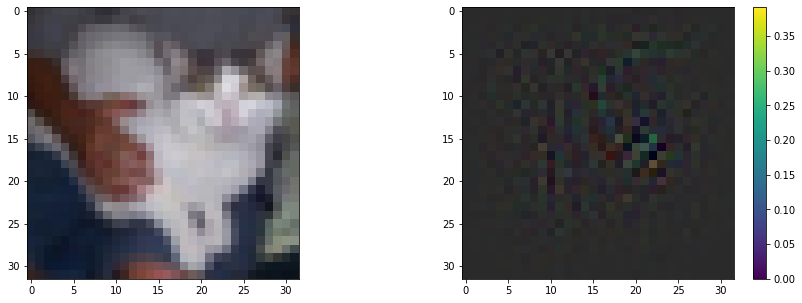

In [484]:
fig, axes = plt.subplots(1,2,figsize=(15,5))
axes[0].imshow(images[26])
i = axes[1].imshow(smap[26][0])
fig.colorbar(i)

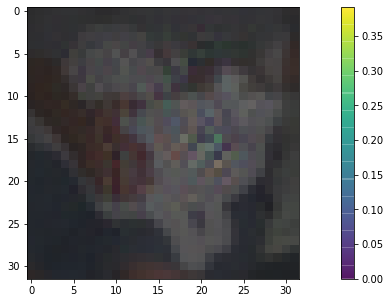

In [487]:
fig, axes = plt.subplots(figsize=(15,5))
axes.imshow(images[26])
i = axes.imshow(smap[26][0],alpha=0.7)
fig.colorbar(i)

### By taking maximum across channels


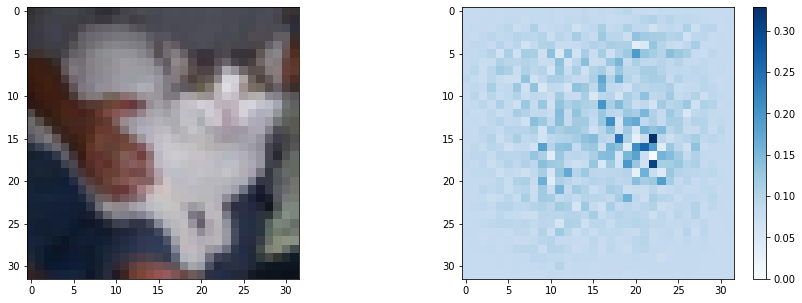

In [450]:
fig, axes = plt.subplots(1,2,figsize=(15,5))
axes[0].imshow(images[26])
i = axes[1].imshow(smap[26][0], cmap="Blues")
fig.colorbar(i)

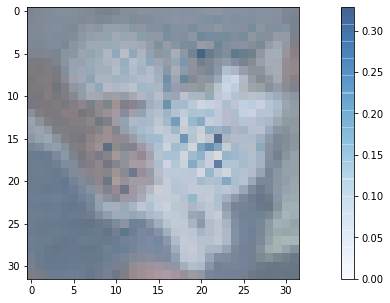

In [439]:
fig, axes = plt.subplots(figsize=(15,5))
axes.imshow(images[26])
i = axes.imshow(smap[26][0],cmap="Blues",alpha=0.5)
fig.colorbar(i)

### Smoothing smap with a gaussian filter

In [451]:
def smooth_smap(saliency_map):
    # Define the Gaussian filter
    gaussian_filter = tf.constant([[0.0625, 0.125, 0.0625], [0.125, 0.25, 0.125], [0.0625, 0.125, 0.0625]], dtype=tf.float32)

    # Expand dimensions of the filter
    gaussian_filter = tf.expand_dims(gaussian_filter, -1)
    gaussian_filter = tf.expand_dims(gaussian_filter, -1)

    # Convolve the saliency map with the Gaussian filter
    smooth_saliency_map = tf.nn.conv2d(tf.expand_dims(saliency_map, -1), gaussian_filter, strides=[1, 1, 1, 1], padding='SAME')
    smooth_saliency_map = tf.squeeze(smooth_saliency_map, -1)

    return smooth_saliency_map

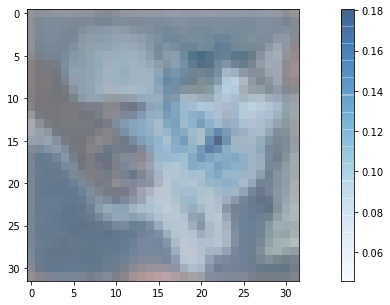

In [453]:
fig, axes = plt.subplots(figsize=(15,5))
axes.imshow(images[26])

smooth_saliency_map = smooth_smap(smap[26])

i = axes.imshow(smooth_saliency_map[0],cmap="Blues",alpha=0.5)
fig.colorbar(i)

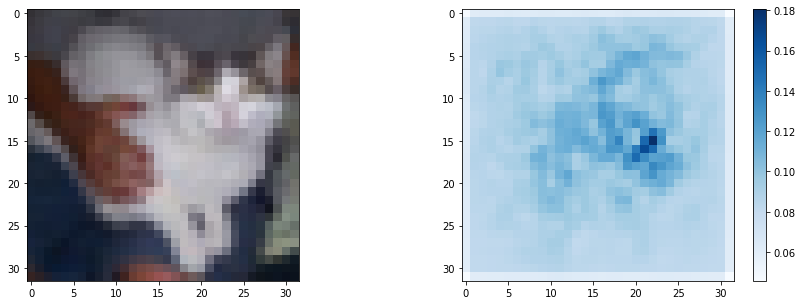

In [455]:
fig, axes = plt.subplots(1,2,figsize=(15,5))
axes[0].imshow(images[26])
i = axes[1].imshow(smooth_saliency_map[0],cmap="Blues")
fig.colorbar(i)

## Adversarial smaps

### Generate Adversarial Images

In [18]:
# basic code for creating adversarial examples
def make_adversarial(imgs=images, lbls=images_lbl, eps=0.01):
    adv_imgs = imgs
    for _ in range(1):  # this loop is a dummy (just one iteration)
        with tf.GradientTape() as tape:
            tape.watch(adv_imgs)
            out = model(adv_imgs)
            xent = loss_fn(lbls, out)

        grads = tape.gradient(xent, adv_imgs)

        # gradient sign method
        grad_sign = tf.sign(grads)
        adv_imgs = adv_imgs + eps*grad_sign
        adv_imgs = tf.clip_by_value(adv_imgs, 0., 1.)

    return adv_imgs

In [19]:
# just a helper
def batch_acc(imgs, lbls):
    out = model(imgs)
    preds = tf.argmax(out, axis=-1, output_type=tf.int32)
    return tf.reduce_mean(tf.cast(tf.equal(lbls, preds), tf.float32))

In [20]:
def make_adversarial_target(imgs=images, lbls=images_lbl, eps=0.01, target=3):
    adv_imgs = imgs
    # if you were to run this loop for many iterations, and remove the
    # gradient sign (using gradients directly, with a learning rate)
    # you basically have the deep dream method. then you could
    # - replace the softmax probsl with logits, hidden activations etc
    # - use a random initialization instead of dataset images
    # - add regularization terms to the "loss"
    # - ...
    for _ in range(1):
        with tf.GradientTape() as tape:
            tape.watch(adv_imgs)

            out = tf.reduce_mean(tf.nn.softmax(model(adv_imgs))[:, target])
        # these gradients are saliency maps for the target class, pretty much
        grads = tape.gradient(out, adv_imgs)

        grad_sign = tf.sign(grads)
        adv_imgs = adv_imgs + eps*grad_sign
        adv_imgs = tf.clip_by_value(adv_imgs, 0., 1.)

    return adv_imgs

In [21]:
images3 = tf.Variable(images2, dtype=float)
images_lbl3 = tf.Variable(images_lbl2)

Original


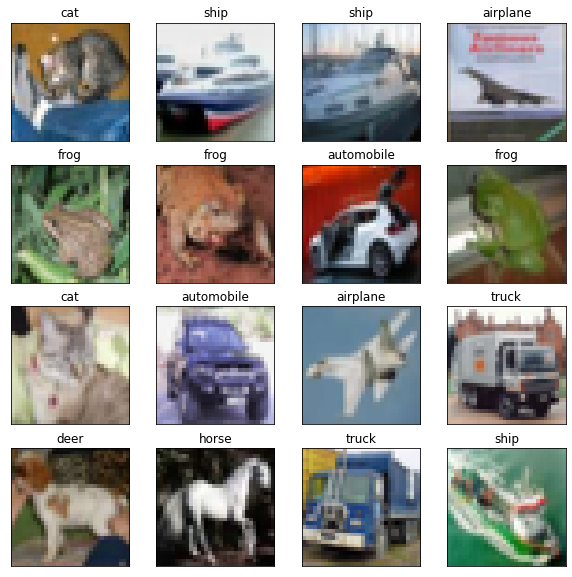

Accuracy: 0.8514000177383423

Adversarial


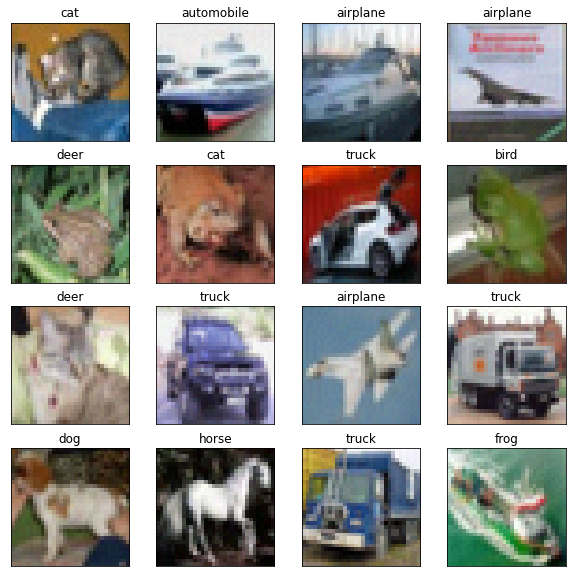

Accuracy: 0.3628000020980835


In [22]:
# plot batch
print("Original")
plt.figure(figsize=(10, 10))

acc_normal = batch_acc(images2, images_lbl2).numpy()
preds_normal = tf.argmax(model(images2), axis=-1)[:16]


for index, label in enumerate(preds_normal):
    plt.subplot(4, 4, index+1)
    plt.imshow(images2[index, :, :, :], vmin=0, vmax=1, aspect="equal")
    plt.title(label_def[label])
    a = plt.gca()
    a.axes.xaxis.set_visible(False)
    a.axes.yaxis.set_visible(False)

plt.show()

print("Accuracy: {}".format(acc_normal))
# print("Predictions...")
# p = tf.argmax(model(images2), axis=-1)[:16]
# for x in p:
#   print(label_def[x])

print("\nAdversarial")
# adv_imgs = make_adversarial(images3, images_lbl3, 0.01)
# also try the targeted attack!
adv_imgs = make_adversarial_target(images3, images_lbl3, 0.01, target=0)

acc_adv = batch_acc(adv_imgs, images_lbl2).numpy()
preds_adv = tf.argmax(model(adv_imgs), axis=-1)[:16]

plt.figure(figsize=(10, 10))
for index, label in enumerate(preds_adv):
    plt.subplot(4, 4, index+1)
    plt.imshow(adv_imgs.numpy()[index, :, :, :], vmin=0, vmax=1, aspect="equal")
    plt.title(label_def[label])
    a = plt.gca()
    a.axes.xaxis.set_visible(False)
    a.axes.yaxis.set_visible(False)

plt.show()

print("Accuracy: {}".format(acc_adv))
# print("Predictions...")
# p = tf.argmax(model(adv_imgs), axis=-1)[:16]
# for x in p:
#   print(label_def[x])

### Actual smap

In [472]:
saliency_map = plot_saliency_map(images2, model)

In [473]:
smap = np.array(saliency_map)

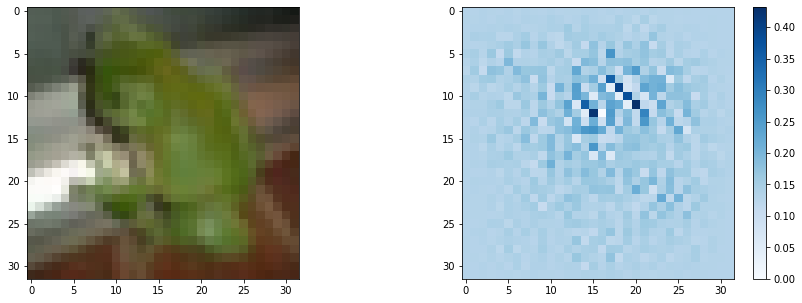

In [474]:
fig, axes = plt.subplots(1,2,figsize=(15,5))
axes[0].imshow(images2[7])
i = axes[1].imshow(smap[7][0],cmap="Blues")
fig.colorbar(i)

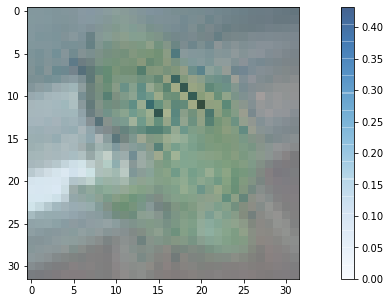

In [463]:
fig, axes = plt.subplots(figsize=(15,5))
axes.imshow(images2[7])
i = axes.imshow(smap[7][0],cmap="Blues",alpha=0.5)
fig.colorbar(i)

### Smap on adversarial image

In [465]:
saliency_map = plot_saliency_map(image=images3, model=model)

In [466]:
smap = np.array(saliency_map)

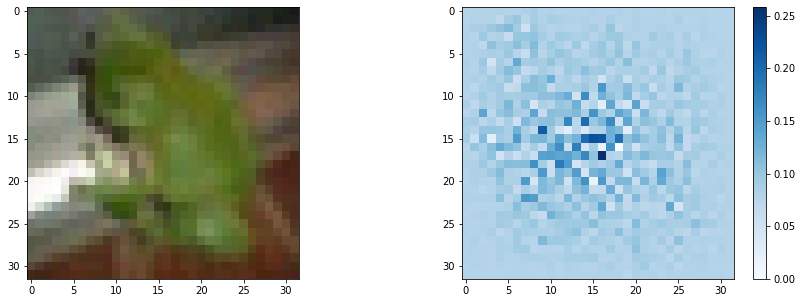

In [467]:
fig, axes = plt.subplots(1,2,figsize=(15,5))
axes[0].imshow(images3[7])
i = axes[1].imshow(smap[7][0],cmap="Blues",alpha=1)
fig.colorbar(i)

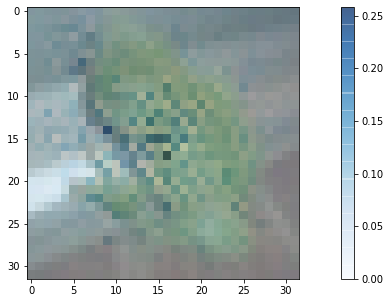

In [468]:
fig, axes = plt.subplots(figsize=(15,5))
axes.imshow(adv_imgs[7])
i = axes.imshow(smap[7][0],cmap="Blues",alpha=0.5)
fig.colorbar(i)

# Activation Maximisation

In [469]:
input_img = images[10]

input_img = tf.Variable(input_img, dtype=tf.float32)

input_img = tf.expand_dims(input_img, 0)

In [ ]:
input_img.shape

TensorShape([1, 32, 32, 3])

In [470]:
# Perform the activation maximization
def activation_max(input_img, num_steps, layer_name = 'conv2d'):

    # Define the layer you want to maximize the activation of
    layer = model.get_layer(layer_name)

    for i in range(num_steps):
        with tf.GradientTape() as tape:
            tape.watch(input_img)
            loss_value = calc_loss(input_img, layer)
        
        grads = tape.gradient(loss_value, input_img)
        grads /= tf.math.reduce_std(grads) + 1e-8 
        input_img = input_img + grads * 0.01
        input_img = tf.clip_by_value(input_img, 0, 1)

    return grads, input_img   

## On adversarial example

In [ ]:
input_img = adv_imgs[5]

input_img = tf.Variable(input_img, dtype=tf.float32)

input_img = tf.expand_dims(input_img, 0)

cat


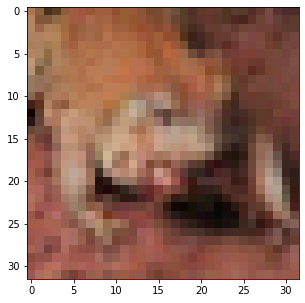

In [ ]:
fig, axes = plt.subplots(figsize=(15,5))
axes.imshow(tf.squeeze(input_img, 0))
x = tf.argmax(model(input_img), axis=-1)
x = x[0]
print(label_def[x])

frog


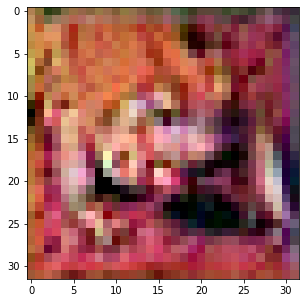

In [ ]:
grads, input_img = activation_max(input_img, 10)
fig, axes = plt.subplots(figsize=(15,5))
axes.imshow(tf.squeeze(input_img, 0))
x = tf.argmax(model(input_img), axis=-1)
x = x[0]
print(label_def[x])

frog


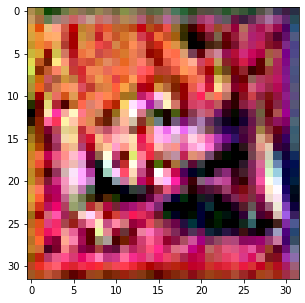

In [ ]:
grads, input_img = activation_max(input_img, 20)
fig, axes = plt.subplots(figsize=(15,5))
axes.imshow(tf.squeeze(input_img, 0))
x = tf.argmax(model(input_img), axis=-1)
x = x[0]
print(label_def[x])

truck


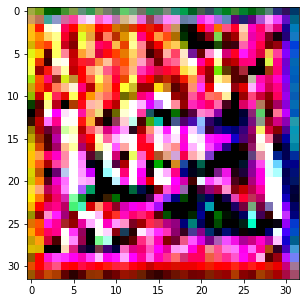

In [ ]:
grads, input_img = activation_max(input_img, 50)
fig, axes = plt.subplots(figsize=(15,5))
axes.imshow(tf.squeeze(input_img, 0))
x = tf.argmax(model(input_img), axis=-1)
x = x[0]
print(label_def[x])

truck


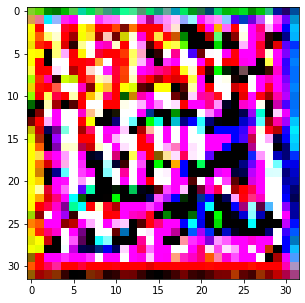

In [ ]:
grads, input_img = activation_max(input_img, 100)
fig, axes = plt.subplots(figsize=(15,5))
axes.imshow(tf.squeeze(input_img, 0))
x = tf.argmax(model(input_img), axis=-1)
x = x[0]
print(label_def[x])

## Results for cat image from dataset

In [109]:
grads, input_img = activation_max(input_img, 2)

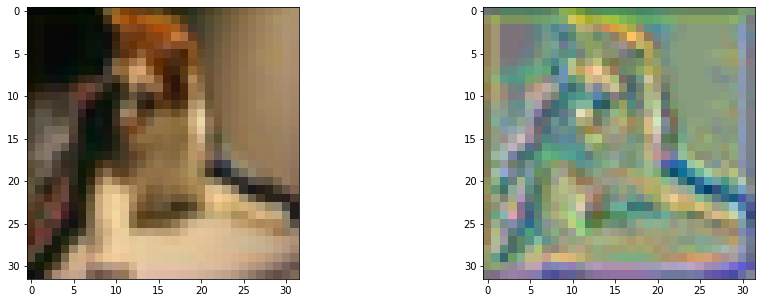

In [110]:
fig, axes = plt.subplots(1,2,figsize=(15,5))
axes[0].imshow(tf.squeeze(input_img, 0))

gradients = (grads - np.min(grads)) / (np.max(grads) - np.min(grads))

axes[1].imshow(tf.squeeze(gradients,0))

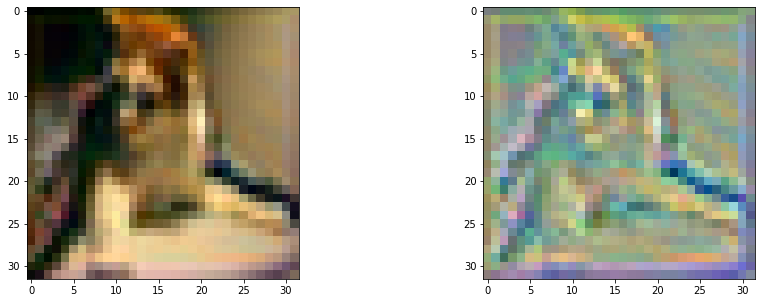

In [112]:
grads, input_img = activation_max(input_img, 5)
fig, axes = plt.subplots(1,2,figsize=(15,5))
axes[0].imshow(tf.squeeze(input_img, 0))

gradients = (grads - np.min(grads)) / (np.max(grads) - np.min(grads))

axes[1].imshow(tf.squeeze(gradients,0))

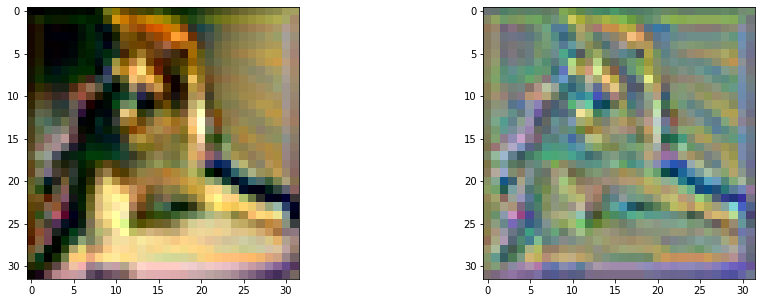

In [114]:
grads, input_img = activation_max(input_img, 10)
fig, axes = plt.subplots(1,2,figsize=(15,5))
axes[0].imshow(tf.squeeze(input_img, 0))

gradients = (grads - np.min(grads)) / (np.max(grads) - np.min(grads))

axes[1].imshow(tf.squeeze(gradients,0))

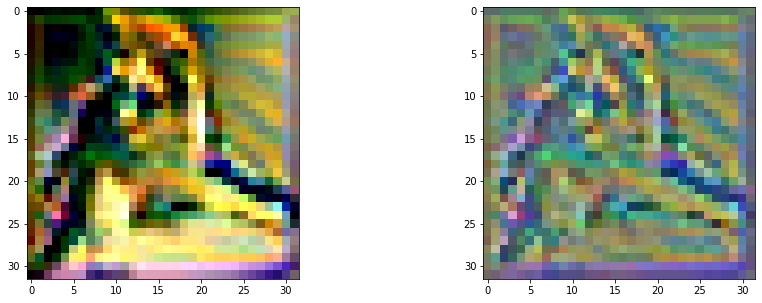

In [116]:
grads, input_img = activation_max(input_img, 20)
fig, axes = plt.subplots(1,2,figsize=(15,5))
axes[0].imshow(tf.squeeze(input_img, 0))

gradients = (grads - np.min(grads)) / (np.max(grads) - np.min(grads))

axes[1].imshow(tf.squeeze(gradients,0))

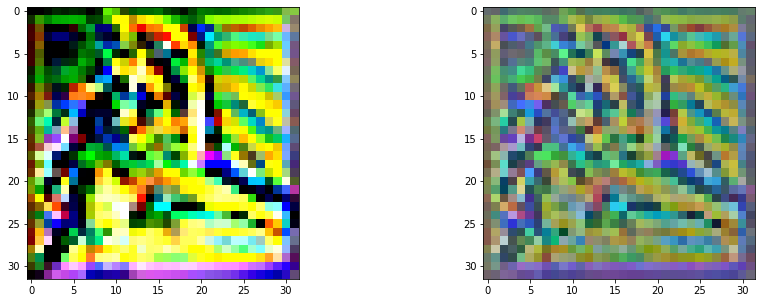

In [118]:
grads, input_img = activation_max(input_img, 50)
fig, axes = plt.subplots(1,2,figsize=(15,5))
axes[0].imshow(tf.squeeze(input_img, 0))

gradients = (grads - np.min(grads)) / (np.max(grads) - np.min(grads))

axes[1].imshow(tf.squeeze(gradients,0))

## Regularization techniques

In [120]:
def blur_loss(input_img):
    kernel = tf.constant([[1, 2, 1], [2, 4, 2], [1, 2, 1]], dtype=tf.float32)
    kernel = kernel / tf.reduce_sum(kernel)
    return tf.nn.conv2d(input_img, kernel, strides=[1, 1, 1, 1], padding='SAME')

def l2_loss(input_img):
    return tf.reduce_sum(tf.square(input_img))

def total_variation_loss(input_img):
    return tf.image.total_variation(input_img)

#-------------------------------------------------------------------------------#
def loss(input_img, layer, loss_type):
  if loss_type == 'l2_loss':
    return tf.reduce_mean(layer(input_img)) + 0.1*l2_loss(input_img)
  elif loss_type == 'blur loss': 
    return tf.reduce_mean(layer(input_img)) + 0.1*blur_loss(input_img)
  else:
    return tf.reduce_mean(layer(input_img)) + 0.1*total_variation_loss(input_img)  

In [128]:
input_img = images[10]

input_img = tf.Variable(input_img, dtype=tf.float32)

input_img = tf.expand_dims(input_img, 0)

In [122]:
# Perform the activation maximization
def activation_max_loss(input_img, num_steps, loss_type, layer_name = 'conv2d',):

    # Define the layer you want to maximize the activation of
    layer = model.get_layer(layer_name)

    for i in range(num_steps):
        with tf.GradientTape() as tape:
            tape.watch(input_img)
            loss_value = loss(input_img, layer, loss_type)
        
        grads = tape.gradient(loss_value, input_img)
        grads /= tf.math.reduce_std(grads) + 1e-8

        # grads = (grads - np.min(grads)) / (np.max(grads) - np.min(grads))
        input_img = input_img + grads * 0.01
        input_img = tf.clip_by_value(input_img, 0, 1)

    return grads, input_img   

### Actual

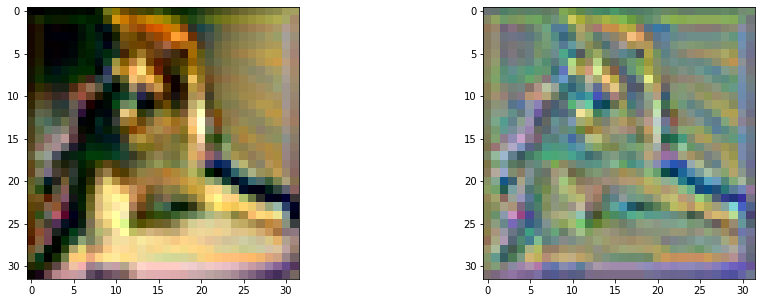

In [123]:
grads, input_img = activation_max(input_img, 10)

fig, axes = plt.subplots(1,2,figsize=(15,5))
axes[0].imshow(tf.squeeze(input_img, 0))

gradients = (grads - np.min(grads)) / (np.max(grads) - np.min(grads))

axes[1].imshow(tf.squeeze(gradients,0))

### Blur loss

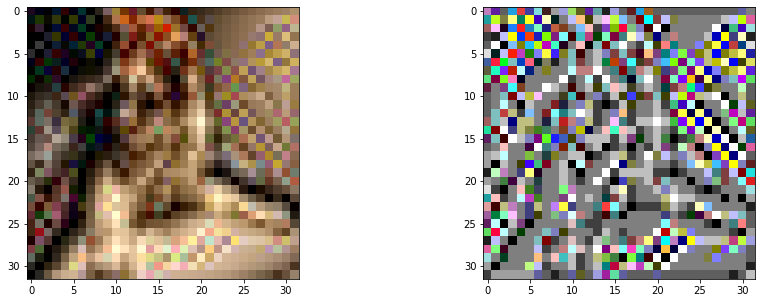

In [125]:
grads, input_img = activation_max_loss(input_img, 10, blur_loss)

fig, axes = plt.subplots(1,2,figsize=(15,5))
axes[0].imshow(tf.squeeze(input_img, 0))

gradients = (grads - np.min(grads)) / (np.max(grads) - np.min(grads))

axes[1].imshow(tf.squeeze(gradients,0))

### Total variation loss

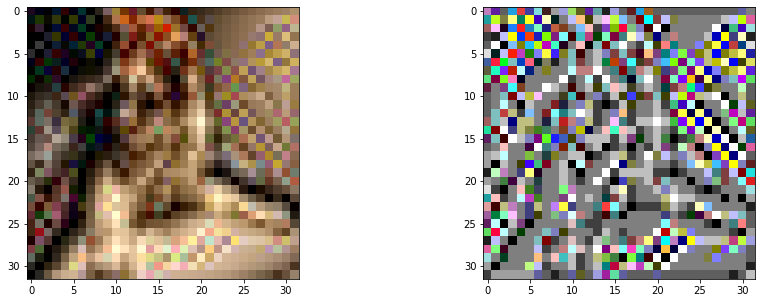

In [127]:
grads, input_img = activation_max_loss(input_img, 10, total_variation_loss)

fig, axes = plt.subplots(1,2,figsize=(15,5))
axes[0].imshow(tf.squeeze(input_img, 0))

gradients = (grads - np.min(grads)) / (np.max(grads) - np.min(grads))

axes[1].imshow(tf.squeeze(gradients,0))

### L2 loss

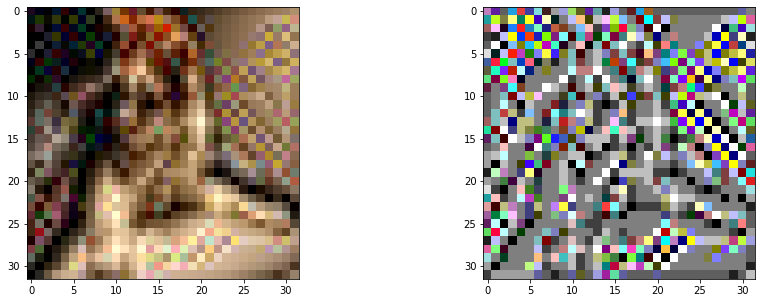

In [129]:
grads, input_img = activation_max_loss(input_img, 10, l2_loss)

fig, axes = plt.subplots(1,2,figsize=(15,5))
axes[0].imshow(tf.squeeze(input_img, 0))

gradients = (grads - np.min(grads)) / (np.max(grads) - np.min(grads))

axes[1].imshow(tf.squeeze(gradients,0))

## Randomly initialized image

In [ ]:
# Create a random input image
input_img = tf.random.uniform(shape=(32, 32, 3), minval=0, maxval=255, dtype=tf.dtypes.float32)

input_img = tf.Variable(input_img, dtype=tf.float32)

input_img = tf.expand_dims(input_img, 0)

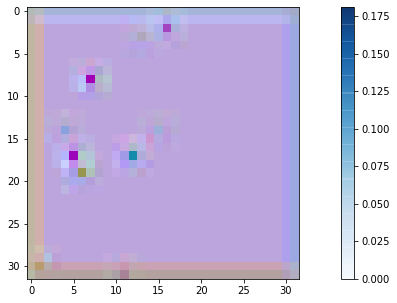

In [ ]:
grads, input_img = activation_max(input_img, 2)

# convert to numpy
grads = grads.numpy()

# normalize between 0 and 1
min_val, max_val = np.min(grads), np.max(grads)
x = (grads - min_val) / (max_val - min_val + keras.backend.epsilon())

fig, axes = plt.subplots(figsize=(15,5))
axes.imshow(tf.squeeze(x, 0))
fig.colorbar(i)

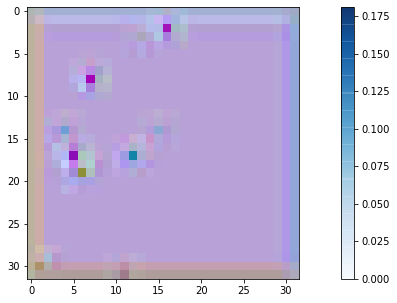

In [ ]:
grads, input_img = activation_max(input_img, 5)

# convert to numpy
grads = grads.numpy()

# normalize between 0 and 1
min_val, max_val = np.min(grads), np.max(grads)
x = (grads - min_val) / (max_val - min_val + keras.backend.epsilon())

fig, axes = plt.subplots(figsize=(15,5))
axes.imshow(tf.squeeze(x, 0))
fig.colorbar(i)

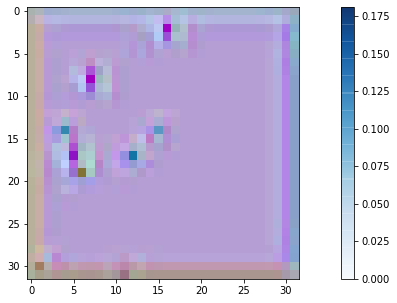

In [ ]:
grads, input_img = activation_max(input_img, 10)

# convert to numpy
grads = grads.numpy()

# normalize between 0 and 1
min_val, max_val = np.min(grads), np.max(grads)
x = (grads - min_val) / (max_val - min_val + keras.backend.epsilon())

fig, axes = plt.subplots(figsize=(15,5))
axes.imshow(tf.squeeze(x, 0))
fig.colorbar(i)

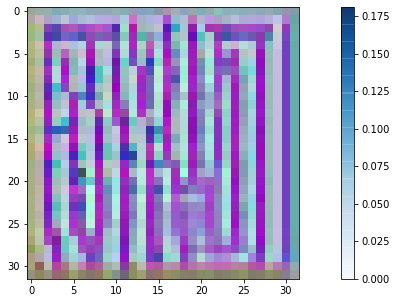

In [ ]:
grads, input_img = activation_max(input_img, 120)

# convert to numpy
grads = grads.numpy()

# normalize between 0 and 1
min_val, max_val = np.min(grads), np.max(grads)
x = (grads - min_val) / (max_val - min_val + keras.backend.epsilon())

fig, axes = plt.subplots(figsize=(15,5))
axes.imshow(tf.squeeze(x, 0))
fig.colorbar(i)

# Extra

## Plotting feature maps

Code of the following function is from kaggle

In [ ]:
def get_feature_maps(model, layer_id, input_image):
    model_ = Model(inputs=[model.input], 
                   outputs=[model.layers[layer_id].output])
    return model_.predict(np.expand_dims(input_image, 
                                         axis=0))[0,:,:,:].transpose((2,0,1))

In [ ]:
def plot_features_map(img_idx=None, layer_idx=[1, 3, 7, 9, 13, 15, 17], 
                      x_test=images, ytest=images_lbl, model=model):
    if img_idx == None:
        img_idx = randint(0, ytest.shape[0])
    input_image = x_test[img_idx]

    fig, ax = plt.subplots(4,2,figsize=(15,15))
    ax[0][0].imshow(input_image)
    ax[0][0].set_title('original img id {} - {}'.format(img_idx, 
                                                        label_def[ytest[img_idx][0]]))
    for i, l in enumerate(layer_idx):
        feature_map = get_feature_maps(model, l, input_image)
        ax[(i+1)//2][(i+1)%2].imshow(feature_map[:,:,0])
        ax[(i+1)//2][(i+1)%2].set_title('layer {} - {}'.format(l, 
                                                              model.layers[l].get_config()['name']))
    return img_idx

1/1 [==============================] - 0s 115ms/step


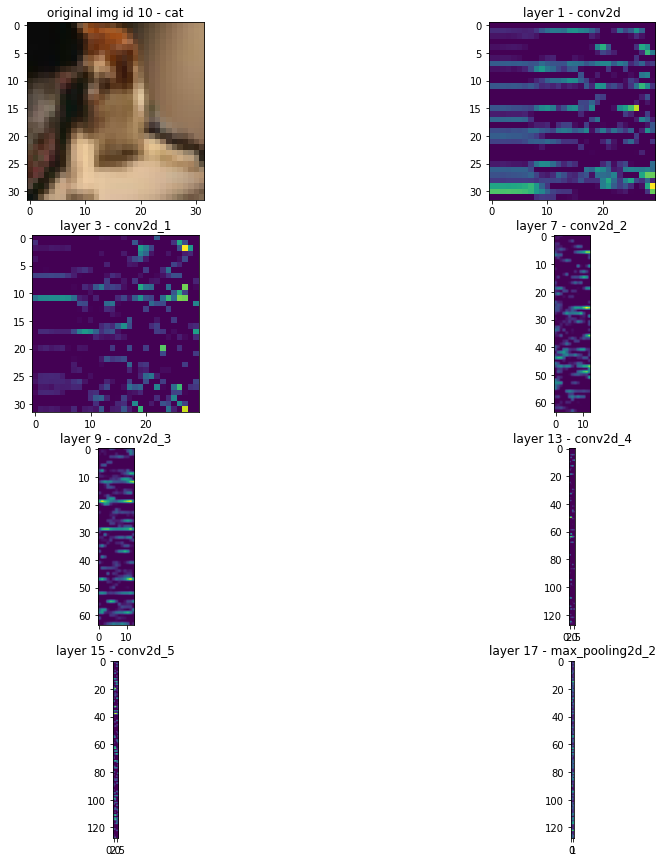

In [ ]:
features_map = plot_features_map(img_idx=10)

## Visualization of the outputs of each of the layers

In [ ]:
def visualize_conv_layer(layer_name):
  
  layer_output=model.get_layer(layer_name).output  #get the Output of the Layer
  intermediate_model=tf.keras.models.Model(inputs=model.input,outputs=layer_output) 
  intermediate_prediction=intermediate_model.predict(test_images[61].reshape(1,32,32,3))
  
  row_size=4
  col_size=4
  
  img_index=0
  print(np.shape(intermediate_prediction))
  
  fig,ax=plt.subplots(row_size,col_size,figsize=(20,10)) 
  for row in range(0,row_size):
    for col in range(0,col_size):
      ax[row][col].imshow(intermediate_prediction[0, :, :, img_index], cmap='gray')
      img_index=img_index+1 #Increment the Index number of img_index variable

1/1 [==============================] - 0s 38ms/step
(1, 30, 30, 32)


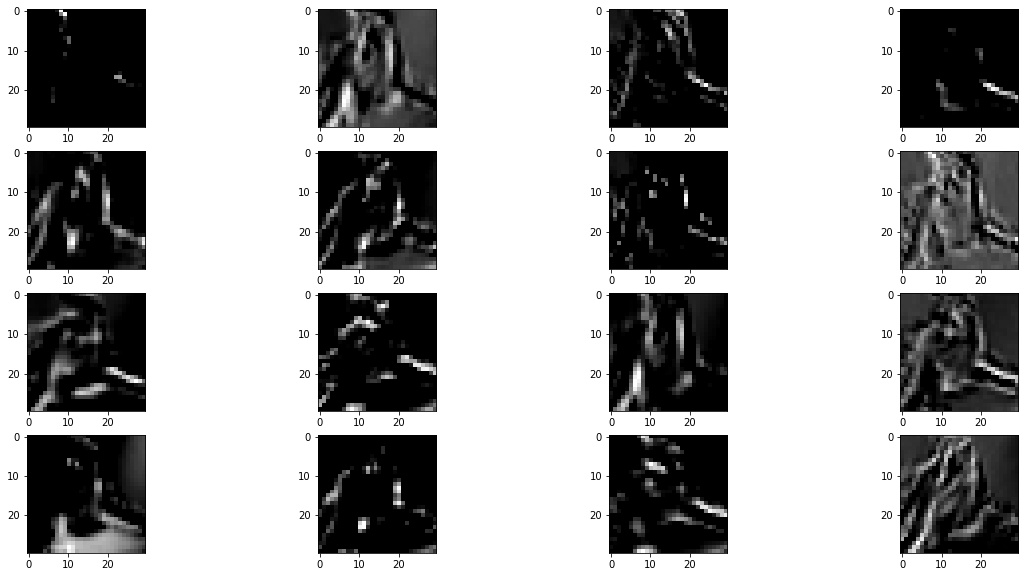

In [ ]:
visualize_conv_layer('conv2d')

1/1 [==============================] - 0s 52ms/step
(1, 30, 30, 32)


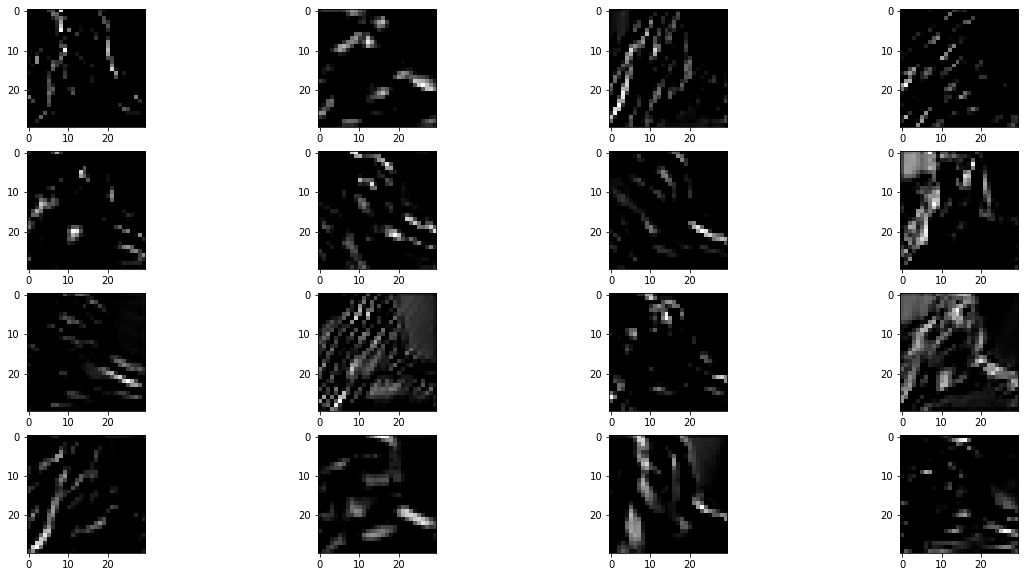

In [ ]:
visualize_conv_layer('conv2d_1')

1/1 [==============================] - 0s 66ms/step
(1, 13, 13, 64)


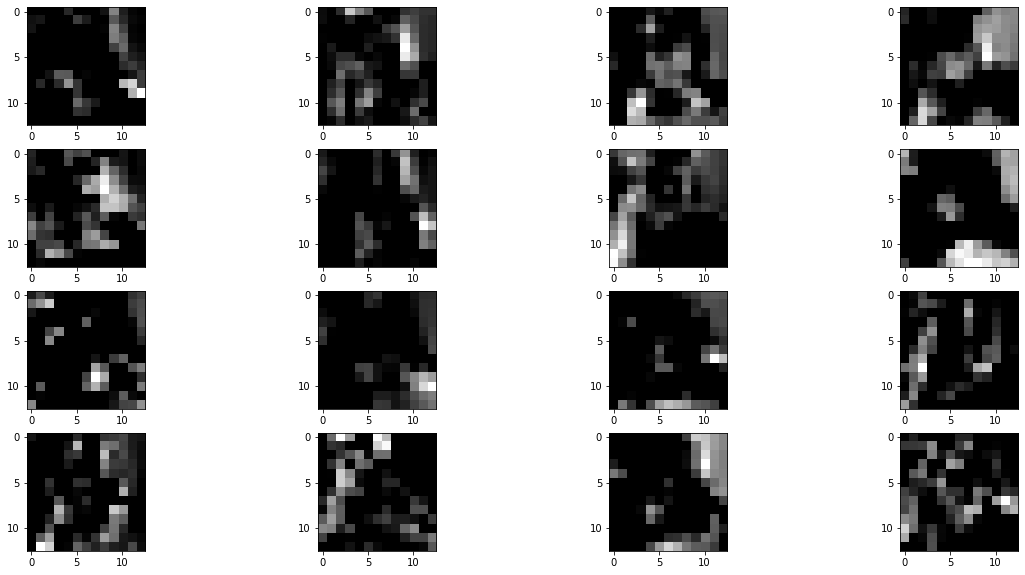

In [ ]:
visualize_conv_layer('conv2d_2')

1/1 [==============================] - 0s 116ms/step
(1, 13, 13, 64)


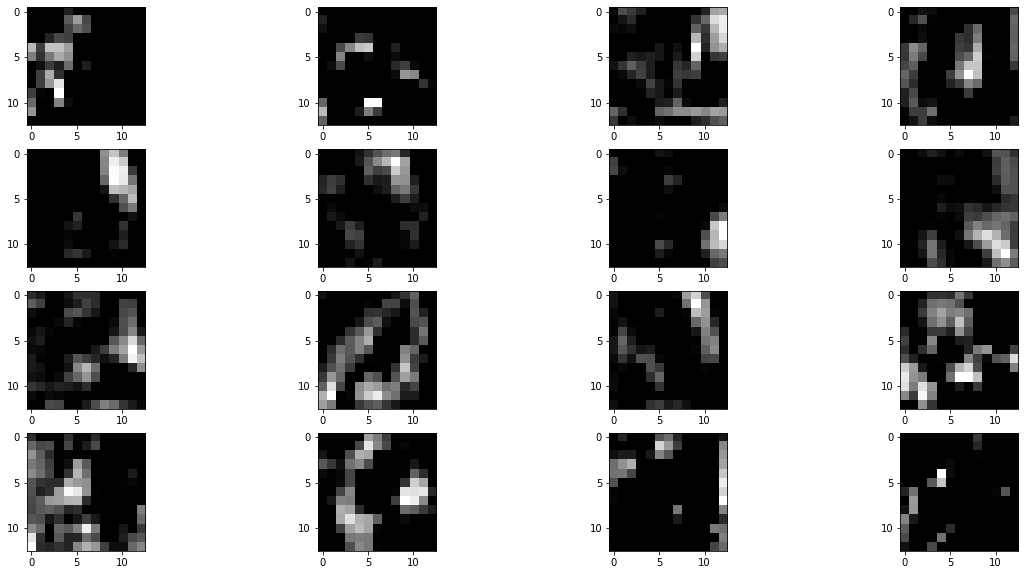

In [ ]:
visualize_conv_layer('conv2d_3')

1/1 [==============================] - 0s 154ms/step
(1, 4, 4, 128)


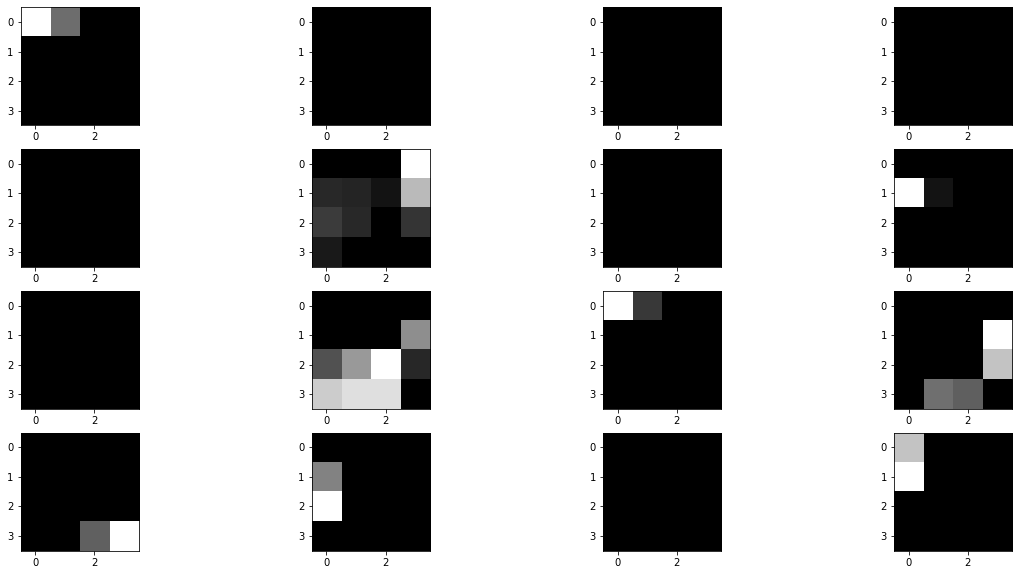

In [ ]:
visualize_conv_layer('conv2d_4')

1/1 [==============================] - 0s 102ms/step
(1, 4, 4, 128)


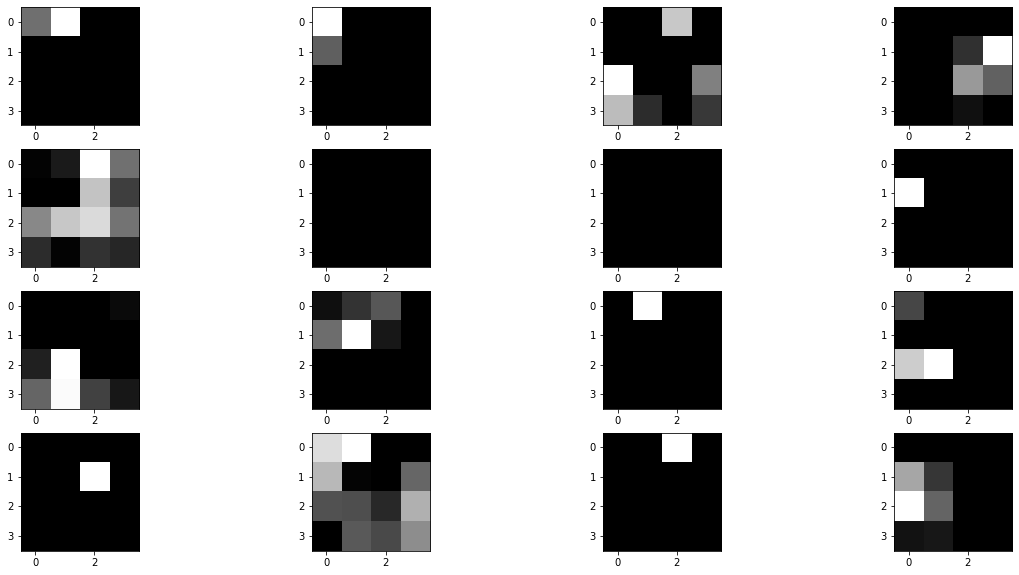

In [ ]:
visualize_conv_layer('conv2d_5')